In [1]:
import sys
sys.path.append('../src')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf

In [3]:
from gait.config import pd
from gait.utils import get_data_by_overlap_percent,get_overlap_data_all_sessions,  split_test_train_by_subjects, remove_invalid_data, get_overlap_data_all_sessions
from gait.training import train_model
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions


In [4]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/home/sanjeev/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
270/270 [==============================] - 11s 23ms/step - loss: 1.4848 - accuracy: 0.3887 - val_loss: 1.1205 - val_accuracy: 0.5549
Epoch 2/100
270/270 [==============================] - 6s 21ms/step - loss: 1.1989 - accuracy: 0.4813 - val_loss: 0.9683 - val_accuracy: 0.6239
Epoch 3/100
270/270 [==============================] - 6s 21ms/step - loss: 1.1415 - accuracy: 0.4912 - val_loss: 0.9957 - val_accuracy: 0.5786
Epoch 4/100
270/270 [==============================] - 6s 20ms/step - loss: 1.1150 - accuracy: 0.4931 - val_loss: 0.9807 - val_accuracy: 0.6101
Epoch 5/100
270/270 [==============================] - 6s 21ms/step - loss: 1.0919 - accuracy: 0.5007 - val_loss: 0.9117 - val_accuracy: 0.6779
Epoch 6/100
270/270 [==============================] - 6s 21ms/step - loss: 1.0832 - accuracy: 0.5101 - val_loss: 0.9028 - val_accuracy: 0.6726
Epoch 7/100
270/270 [==============================] - 6s 21ms/step - loss: 1.0676 - accuracy: 0.5145 - val_loss: 0.8898 - val_accuracy

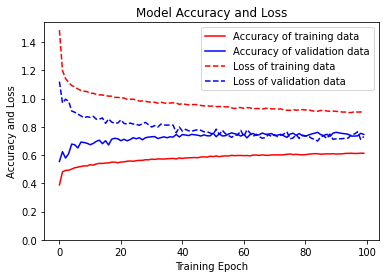

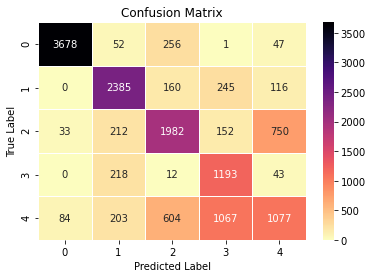

In [5]:
overlapPercents = [50]
# overlapPercents = [0]
# exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'LLZjAPTyj7muHsEf',
#                     'MMuX9YIh4NTbLZLM', 'cbOZWnI7s1y8oLD4', 'PE8D53oX060qLbdX', 'xYdtS1F8tDyjEIgN', 'sUZBISq61Y7I5tqQ']
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', '0DXZFsYOfgqsYe0Z',
                    '0UXFxu10k0En1vDK',
                    'KNmC3LADpLyH5qJA',
                    'WAb2Ztvv2ux95P4Q',
                    'YbJVcb4vFFjKKlfe',
                    'ewpnQDEzR8hTqPRY',
                    'kPNKVxgIznp3Vskg',
                    'qyP4saGxcV9UfeQI', ]
for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.8)

        model, history, evaluation_history = train_model(
            X_train, y_train, X_test, y_test, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100, variant="build_cnn2")
        save_history(history, OVERLAP_PERCENT)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions(
            model, X_test, y_test)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)
